# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [108]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import scipy.stats as ss
import pandas as pd

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from scipy.stats import bernoulli, multinomial
from tqdm import tqdm

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [110]:
np.seterr(divide = 'ignore')
np.warnings.filterwarnings('ignore')
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        mean,var=norm.fit(X)
        self.mean=mean
        if var==0.0:
            self.var=0.000001
        else:
            self.var=var
   
    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # Note the input value val could be a vector rather than a single value
        prob_vec=norm.logpdf(val, loc=self.mean, scale=self.var) 
        
        return prob_vec
        

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        unique,count=np.unique(X,return_counts=True)
        self.p_vect =dict(zip(unique,count/np.sum(count)))
    

    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        prob=np.full(val.shape, 0.01)
        for cat,value in self.p_vect.items():
            idx= np.where(val==cat)
            prob[idx]=value
        
        return np.log(prob)
        

# Distribution for categorical features
class CatFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        unique,count=np.unique(X,return_counts=True)
        self.p_vect =dict(zip(unique,count/np.sum(count)))
        
    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation. 
        # You need to replace it by your own code.
#         rv = multinomial(10, self.p_vect)
#         prob_vec = rv.pmf(val) 
        prob=np.full(val.shape, 0.01)
        for cat,value in self.p_vect.items():
            idx= np.where(val==cat)
            prob[idx]=value
        return np.log(prob)
    
    

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [111]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        ''' Initialization: Store distribution object for each feature and class 
            into  list "self.X_rv_all_class" 
            "self.X_dist_all_class": list of distribution using distribution class object
                size= num_classes * num_features
                First index gives class
                Second index gives feature
            
        '''
        #list of list where each inside list contain rv for each class label (Class*features)
        self.X_dist_all_class=[]
        for clas in range(num_classes):
            X_dist_per_class=[]
            for feat_type in feature_types:
                if feat_type=='r':
                    rv=ContFeatureParam()
                elif feat_type=='b':
                    rv=BinFeatureParam()
                elif feat_type=='c':
                    rv=CatFeatureParam()
                else:
                    print("Error:Unkown Feature type Detected")
                    raise
                X_dist_per_class.append(rv)
        
            self.X_dist_all_class.append(X_dist_per_class)
            
        self.num_classes=num_classes
        
        self.y_dist=np.zeros(num_classes)
        
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        ''' Function: Calculates 𝜃𝑗𝑐 for each class and column by calling estimate method
            of all rv objects intialized in __init__
        '''
        
        for clas in range(self.num_classes):
            idx= np.where(y == clas)
            X_given_c=X[idx]
            
            for feat_idx in range(X.shape[1]):
                
                X_feat_given_c=X_given_c[:,feat_idx]
                
                self.X_dist_all_class[clas][feat_idx].estimate(X_feat_given_c)

            self.y_dist[clas]=np.sum(y==clas)/y.size   
        
        
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        
        prob_y_posterior=np.zeros((self.num_classes,X.shape[0]))
        # print(prob_y_posterior.shape)

        for clas in range(self.num_classes):
            prob_y_c=np.zeros(X.shape[0])
            prob_X_c=np.zeros(X.shape[0])
            prob_y_c+= np.log(self.y_dist[clas])
            
            for feat in range(X.shape[1]):
                prob_feat_c = self.X_dist_all_class[clas][feat].get_probability(X[:,feat])
                prob_X_c += prob_feat_c
            prob_y_posterior[clas] = prob_y_c + prob_X_c
            
        #normalizing 
        prob_y_posterior=prob_y_posterior
            
        pred_class=np.argmax(prob_y_posterior,axis=0)
        
        return pred_class
      

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [112]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)

test_accuracy = np.mean(yhat == ytest)
test_error = np.mean(yhat != ytest)

print("Accuracy:", test_accuracy)
print(X.shape)
test_error

Accuracy: 0.9666666666666667
(150, 4)


0.03333333333333333

## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [113]:
from sklearn.linear_model import LogisticRegression
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    for run in tqdm(range(num_runs)):
        N, D = X.shape
        Ntrain = int(0.8 * N)
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
        
        for split in range(num_splits):
            n, d = Xtrain.shape
            Ntrain = int(0.1*(split+1) * n)
            Xtrain_split=Xtrain[:Ntrain]
            ytrain_split=ytrain[:Ntrain]
            
            # NBC Classifier fit and predict
            nbc.fit(Xtrain_split, ytrain_split)
            yhat_nbc=nbc.predict(Xtest)
            
            # LR Classifier fit and predict
            lr.fit(Xtrain_split, ytrain_split)
            yhat_lr=lr.predict(Xtest)
            
            #Classification error
            tst_errs_nbc[split] += np.mean(yhat_nbc != ytest)
            tst_errs_lr[split] += np.mean(yhat_lr != ytest)
    
    tst_errs_nbc /=num_runs
    tst_errs_lr /=num_runs
    
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

The utility function below defines the function for plotting. 

In [114]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

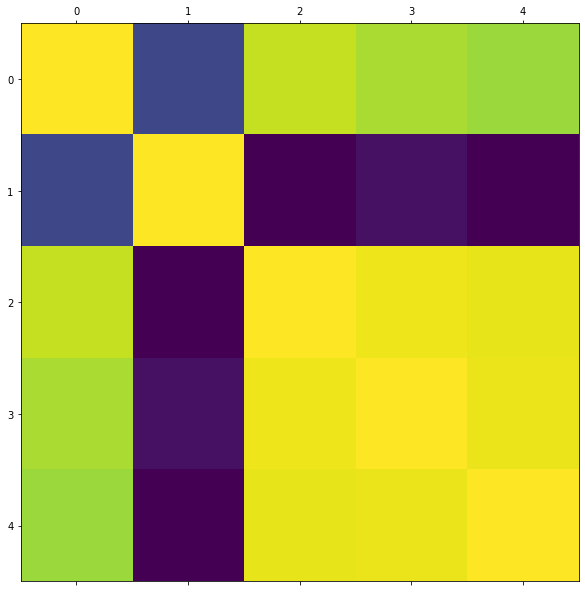

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
species,0.782561,-0.426658,0.949035,0.956547,1.000000


In [115]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

#Loaded the dataset and correlation matrix is calculated to see the correlation between the label and the features and 
#the features that bring least variance in the output are discarded in each of the datasets

iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))

plt.matshow(iris.corr())
plt.show()

corr_matrix = iris.corr()
corr_matrix


100%|██████████| 200/200 [00:37<00:00,  5.32it/s]


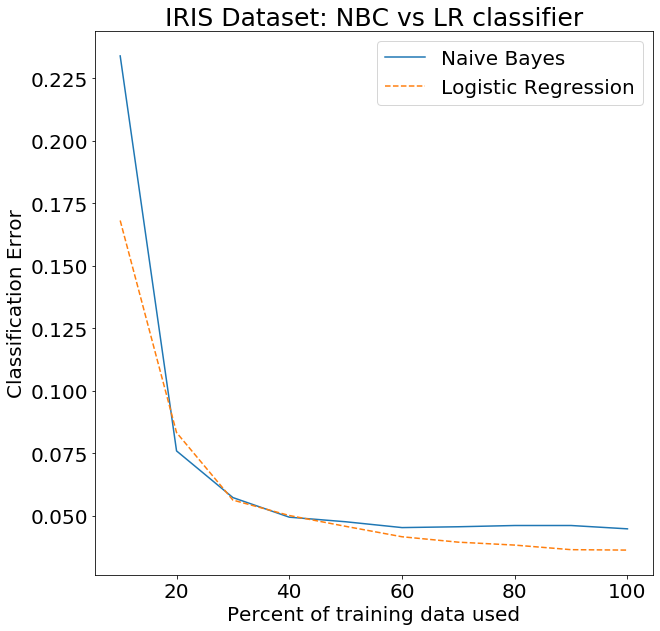

In [116]:

X= iris.iloc[:,:4].to_numpy()
y= iris.iloc[:,4].to_numpy()

classes= np.unique(y)
#classifier initializations
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=classes.size)
lr_iris=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_iris, lr_iris, X, y, num_runs=200, num_splits=10)

makePlot(tst_errs_nbc, tst_errs_lr, title="IRIS Dataset: NBC vs LR classifier")


**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


In [117]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('../Data/voting.csv')
CorrMatrix=voting.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
CorrMatrix["label"].sort_values(ascending=False)


label                                     1.000000
physician-fee-freeze                      0.795967
adoption-of-the-budget-resolution         0.653350
aid-to-nicaraguan-contras                 0.624716
el-salvador-aid                           0.584265
crime                                     0.538348
education-spending                        0.536044
anti-satellite-test-ban                   0.454085
mx-missile                                0.445360
superfund-right-to-sue                    0.443033
duty-free-exports                         0.432993
religious-groups-in-schools               0.358753
handicapped-infants                       0.343765
synfuels-corporation-cutback              0.323262
immigration                               0.081648
water-project-cost-sharing                0.018560
export-administration-act-south-africa   -0.342197
Name: label, dtype: float64

100%|██████████| 200/200 [00:09<00:00, 20.53it/s]


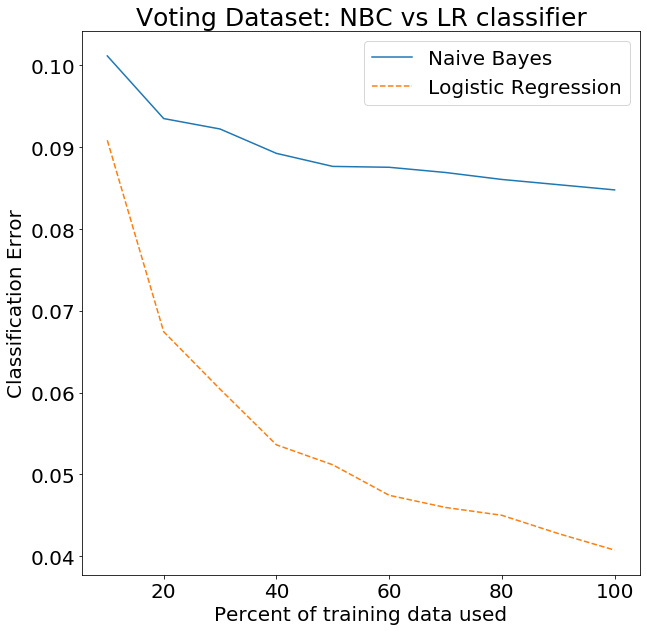

In [118]:
#The correlation of the features "water-project-cost-sharing" and "immigration" with the label are close to zero. 
#Thus, it can be derived that they do not influence significantly the result of the election and they are likely to add noise in the data. 
#Therefore, these features have been dropped.
voting = voting.dropna()
voting=voting.drop("water-project-cost-sharing", axis=1)
X_raw= voting.iloc[:,1:17].to_numpy()


#y encoder
y_raw= pd.Series(voting.iloc[:,0], dtype = 'string')
l = LabelEncoder().fit(y_raw)
y = l.transform(y_raw)
classes= np.unique(y)

#X encoder
X = pd.DataFrame(X_raw)
list1 =[]
for i in range(X.shape[1]):
    lb = LabelBinarizer()
    X.iloc[:,i] = pd.Series(X.iloc[:,i], dtype = 'string')
    list1.append(lb.fit_transform(X.iloc[:,i]))
X = np.array(list1)
X = np.squeeze(X, axis = 2)
X = np.swapaxes(X, 0,1)
nbc_voting = NBC(feature_types=['b', 'b', 'b', 'b', 'b','b', 'b', 'b', 'b', 'b','b', 'b', 'b', 'b', 'b', 'b'], num_classes=classes.size)
lr_voting=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_voting, lr_voting, X, y, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="Voting Dataset: NBC vs LR classifier")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


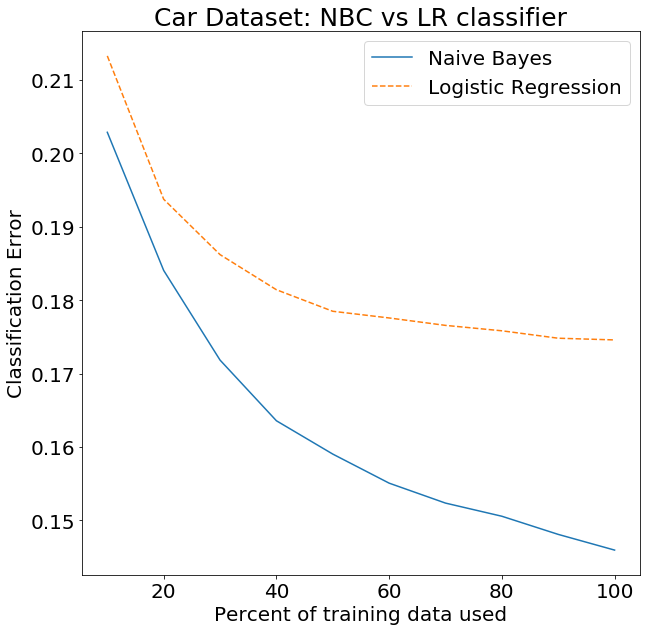

In [119]:
from pandas.api.types import CategoricalDtype
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
#Loaded the dataset and correlation matrix is calculated to see the correlation between the label and the features and 
#the features that bring least variance in the output are discarded in each of the datasets
car = pd.read_csv('../Data/car.csv')

# Created category types.
buying_type = CategoricalDtype(['low','med','high','vhigh'], ordered=True)
maint_type = CategoricalDtype(['low','med','high','vhigh'], ordered=True)
doors_type = CategoricalDtype(['2','3','4','5more'], ordered=True)
persons_type = CategoricalDtype(['2','4','more'], ordered=True)
lug_boot_type = CategoricalDtype(['small','med','big'], ordered=True)
safety_type = CategoricalDtype(['low','med','high'], ordered=True)
acceptability_type = CategoricalDtype(['unacc','acc','good','vgood'], ordered=True)

# Converted all categorical values to category type.
car.buying = car.buying.astype(buying_type)
car.maint = car.maint.astype(maint_type)
car.doors = car.doors.astype(doors_type)
car.persons = car.persons.astype(persons_type)
car.lug_boot = car.lug_boot.astype(lug_boot_type)
car.safety = car.safety.astype(safety_type)
car.acceptability = car.acceptability.astype(acceptability_type)


# Converted categories into integers for each column.
car.buying=car.buying.replace({'low':0, 'med':1, 'high':2, 'vhigh':3})
car.maint=car.maint.replace({'low':0, 'med':1, 'high':2, 'vhigh':3})
car.doors=car.doors.replace({'2':0, '3':1, '4':2, '5more':3})
car.persons=car.persons.replace({'2':0, '4':1, 'more':2})
car.lug_boot=car.lug_boot.replace({'small':0, 'med':1, 'big':2})
car.safety=car.safety.replace({'low':0, 'med':1, 'high':2})
car.acceptability=car.acceptability.replace({'unacc':0, 'acc':1, 'good':2, 'vgood':3})

y= np.array(car.iloc[:,6])
classes= np.unique(y)

# X encoder
X= car.iloc[:,0:6]
list1 =[]
for i in range(X.shape[1]):
    X.iloc[:,i] = np.array(X.iloc[:,i], dtype = 'int')
    list1.append(X.iloc[:,i])
X = np.array(list1)
X = np.swapaxes(X, 0,1)

nbc_car = NBC(feature_types=['c','c','c','c','c','c'], num_classes=classes.size)
lr_car=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_car, lr_car, X, y, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="Car Dataset: NBC vs LR classifier")

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

In [120]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
#Loaded the dataset and correlation matrix is calculated to see the correlation between the label and the features and 
#the features that bring least variance in the output are discarded in each of the datasets
cancer = pd.read_csv('../Data/breast-cancer.csv')
CorrMatrix=cancer.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
CorrMatrix["Class"].sort_values(ascending=False)



Class          1.000000
inv-nodes      0.268118
node-caps      0.241480
irradiat       0.193912
menopause     -0.048973
breast        -0.058646
breast-quad   -0.067409
age           -0.102081
tumor-size    -0.116745
deg-malig     -0.299400
Name: Class, dtype: float64

100%|██████████| 200/200 [00:11<00:00, 17.95it/s]


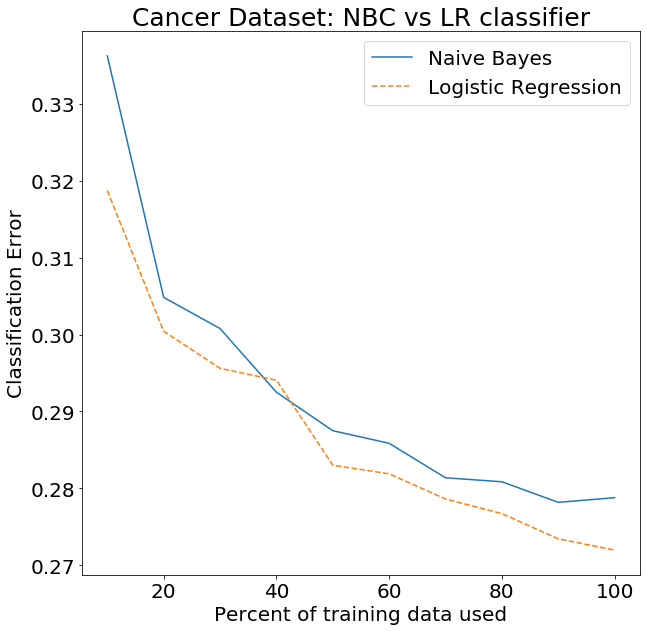

In [121]:

cancer=cancer.drop("menopause", axis=1)
cancer=cancer.drop("breast", axis=1)
cancer=cancer.drop("breast-quad", axis=1)

# y encoder
y_raw= np.array(cancer.iloc[:,0])
l = LabelEncoder().fit(y_raw)
y = l.transform(y_raw)
classes= np.unique(y)

#X encoder
X_raw= cancer.iloc[:,1:17]
X = pd.DataFrame(X_raw)
list1 =[]
for i in range(X.shape[1]):
    l = LabelEncoder()
    X.iloc[:,i] = pd.Series(X.iloc[:,i], dtype = 'string')
    list1.append(l.fit_transform(X.iloc[:,i]))
X = np.array(list1)
X = np.swapaxes(X, 0,1)

nbc_cancer = NBC(feature_types=['c','c','c','c','b','c','b','c','b'], num_classes=classes.size)
lr_cancer=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_cancer, lr_cancer, X, y, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="Cancer Dataset: NBC vs LR classifier")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

100%|██████████| 200/200 [00:27<00:00,  7.33it/s]


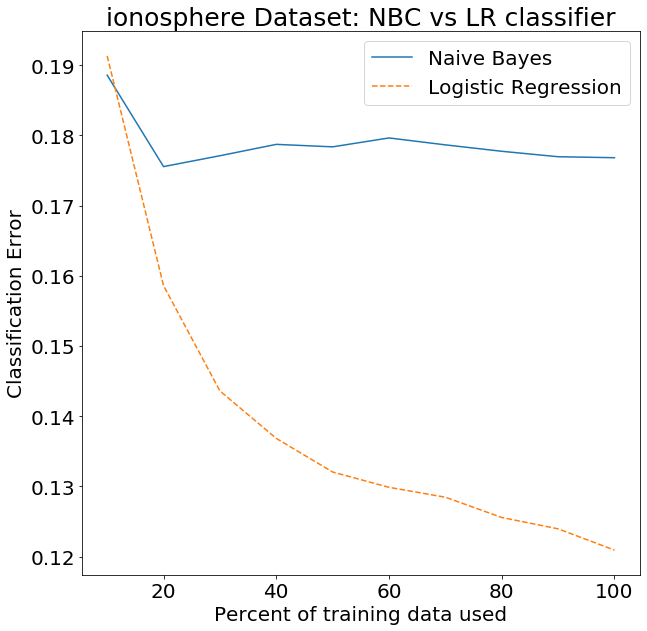

In [122]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
ionosphere = pd.read_csv('../Data/ionosphere.csv')
# X= ionosphere.iloc[:,:34].to_numpy()
X_train = ionosphere.iloc[:,:34].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X_train)


y_raw= ionosphere.iloc[:,-1].to_numpy()

#y encoder
y = LabelEncoder().fit_transform(y_raw)
classes= np.unique(y)

#classifier initializations
nbc_ionosphere = NBC(feature_types=['b','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r'], num_classes=classes.size)
lr_ionosphere=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_ionosphere, lr_ionosphere, X, y, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="ionosphere Dataset: NBC vs LR classifier")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################


**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

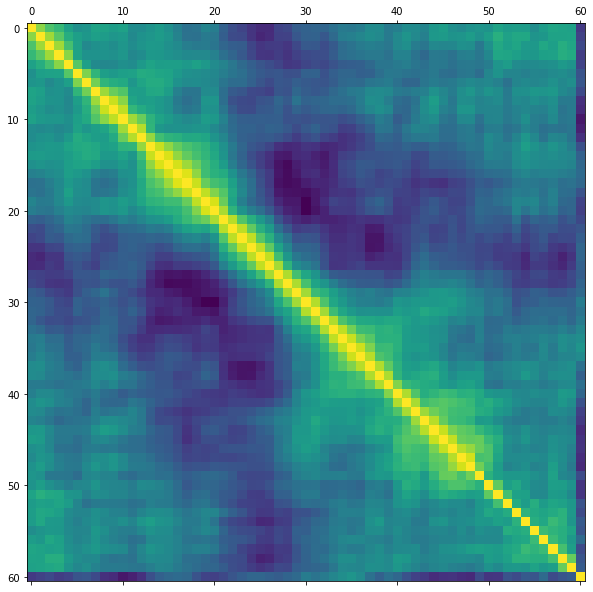

In [123]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
#Loaded the dataset and correlation matrix is calculated to see the correlation between the label and the features and 
#the features that bring least variance in the output are discarded in each of the datasets
sonar = pd.read_csv('../Data/sonar.csv')
CorrMatrix=sonar.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
CorrMatrix["label"].sort_values(ascending=False)
plt.matshow(sonar.corr())
plt.show()


In [124]:
from sklearn.preprocessing import StandardScaler
X_train = sonar.iloc[:,:60].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X_train)



100%|██████████| 200/200 [00:40<00:00,  4.89it/s]


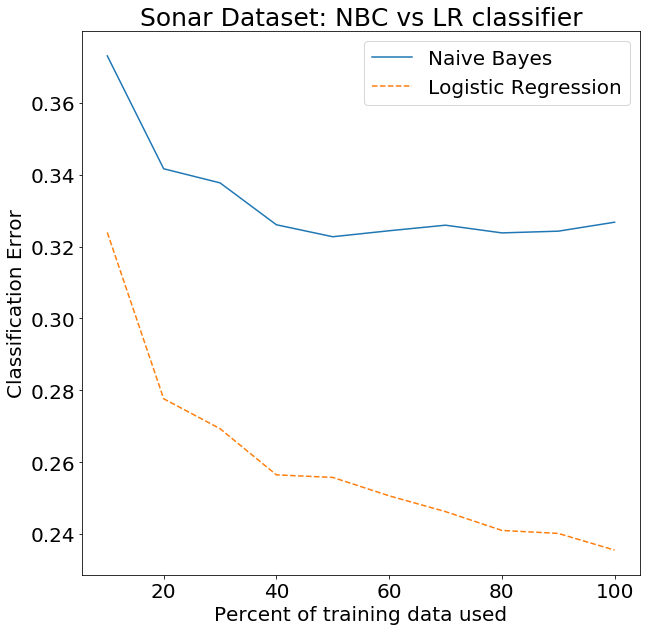

In [125]:
y_raw= sonar.iloc[:,-1].to_numpy()

#y encoder
y = LabelEncoder().fit_transform(y_raw)
classes= np.unique(y)

#classifier initializations
nbc_sonar = NBC(feature_types=['r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r','r'], num_classes=classes.size)
lr_sonar=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_sonar, lr_sonar, X, y, num_runs=200, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="Sonar Dataset: NBC vs LR classifier")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

## Project 2 brief report:
1.	**<u> Classes ContFeatureParam, BinFeatureParam and CatFeatureParam </u>**: Completed the estimation and get_probability functions for the three data types : 
Continuous, binary and categorical respectively. 



-	**<u> estimation </u>**:  Calculates the mean and variance of data distribution in ContFeatureParam, estimated probability of 1’s in the binary distribution of data, estimated probability vector of each category data in data distribution.



-	**<u> get_probability </u>**: Calculates the probability density of a value in the distribution. A small alpha value is added in case the probability is 0 for alpha smoothening.



2.	**<u> Class NBC </u>**: We begin by first calling objects of the classes in point 1 based on the type of features passed in the input dataset in feature_types. There are Classes*features total objects in this list of lists. 



-	**<u>Fit</u>**: Calculates the estimators for the three data types depending on the features and normalizes the data for the three label types. This creates a list of lists for each class and each label hence there are classes*features.




-	**<u>Predict</u>**: For each feature in the input, probability of each class label is calculated by calling the get_probability function of the classes in point1 for different features types. The label with the maximum probability is predicted. This is the posterior probability which is the obtained by multiplying the prior and likelihood calculated.



3.	**<u>Dataset Loading and Preprocessing</u>**:
Data is first loaded and then divided into 80/20 for train/test.
Data is first preprocessed since strings cannot directly passed to the algorithm to make any predictions.
Feature types are passed to class NBC in point 2 and the algorithm is first trained and then predict function is called to predict the most likely label for test dataset.
**Preprocessing**: This includes filling the NAN with 0’s and using encoder for label encoding (binary and categorical). This also includes scaling the data with mean 0 and variance 1 for datasets where different features have different measuring scale. We also removed the columns which didn’t provide any variance to the output and hence had no contribution to the prediction. We dropped the rows where values were missing during prediction. 



4.	**<u>compareNBCvsLR</u>**: This is the function which then calculates the test error for both NBC and LR algorithm and plots them to see the comparison between the two algorithm errors for the test Dataset.




**Result**
5.	**Hence for each dataset depending on the features data is preprocessed and then the functions to then make the model -> prediction ->error in test in LR/NBC-> Plot errors is done.** 
